In [ ]:
import pandas as pd
import mlflow
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, fbeta_score

In [ ]:
data = pd.read_parquet('tokenized.parquet')
data = data.replace({"transportation costs":"transportation_costs"})

X = data[['purpose']]
y = data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def save_fasttext_format(X, y, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for text, label in zip(X['purpose'], y):
            f.write(f"__label__{label} {text}\n")

save_fasttext_format(X_train, y_train, "train_ft.txt")
save_fasttext_format(X_test, y_test, "test_ft.txt")

model = fasttext.train_supervised(input="train_ft.txt", lr=0.1, epoch=25, wordNgrams=2, verbose=2)


def predict_fasttext(model, X):
    return [model.predict(text)[0][0].replace('__label__', '') for text in X['purpose']]

preds_class = predict_fasttext(model, X_test)

f1_macro = f1_score(y_test, preds_class, average='macro')
f1_micro = f1_score(y_test, preds_class, average='micro')
f1_weighted = f1_score(y_test, preds_class, average='weighted')
fbeta_macro = fbeta_score(y_test, preds_class, average='macro', beta=0.5)

print("F1 macro:", f1_macro)
print("F1 micro:", f1_micro)
print("F1 weighted:", f1_weighted)
print("F0.5 macro:", fbeta_macro)
print(classification_report(y_test, preds_class))


with mlflow.start_run():
    mlflow.set_tag('description', 'fasttext baseline')
    mlflow.log_params({
        'model': 'fasttext',
        'lr': 0.1,
        'epoch': 25,
        'wordNgrams': 2,
        "random_state":42,
        "test_size":0.2
    })
    mlflow.log_metric("f1_macro", f1_macro)
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("f1_weighted", f1_weighted)
    mlflow.log_metric("fbeta_0.5_macro", fbeta_macro)
    model.save_model("fasttext_model.ftz")
    mlflow.log_artifact("fasttext_model.ftz")
    with open("classification_report.txt", "w") as f:
        f.write(classification_report(y_test, preds_class))
        mlflow.log_artifact("classification_report.txt")

Логи ML Flow

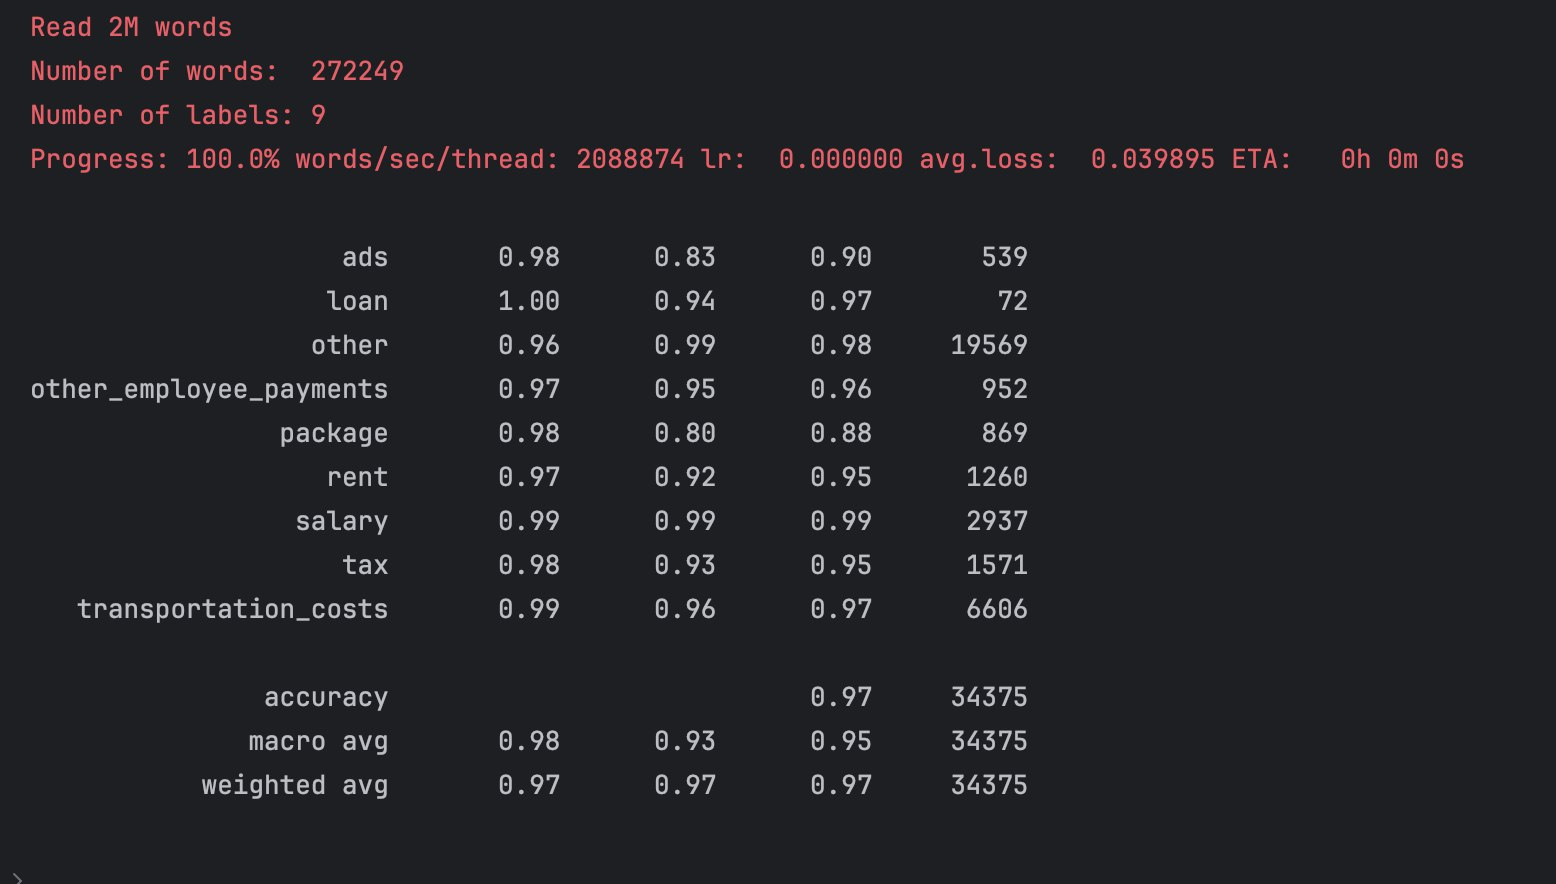